In [10]:
import sys
import cartopy
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from scipy.interpolate import griddata
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

In [11]:
def read_rst_wb(file_path, lis_rst_path):
    
    '''
    read rst wb
    '''
    
    print("read_rst_wb")
    lis_rst     = Dataset(lis_rst_path, mode='r')
    wb          = lis_rst.variables["LAI"][:,:]
    wbice       = lis_rst.variables["WBICE"][:,:]
    GWwb        = lis_rst.variables["GWWB"][:]
    WTD         = lis_rst.variables["WTD"][:]
    lat_in      = lis_rst.variables["lat"][:]  
    lon_in      = lis_rst.variables["lon"][:]  
    
    file        = Dataset(file_path, mode='r')
    lat_out     = file.variables["lat"][:,:]
    lon_out     = file.variables["lon"][:,:]
    nlat        = len(lat_out[:,0])
    nlon        = len(lon_out[0,:])
    nsoil       = 6
    
    wb_regrid   = np.zeros((nsoil,nlat,nlon))
    wbice_regrid= np.zeros((nsoil,nlat,nlon))
    
    for l in np.arange(6):
        wb_regrid[l,:,:]    = griddata((lon_in, lat_in), wb[l,:], (lon_out, lat_out), method="linear")
        wbice_regrid[l,:,:] = griddata((lon_in, lat_in), wbice[l,:], (lon_out, lat_out), method="linear")
        
    GWwb_regrid = griddata((lon_in, lat_in), GWwb, (lon_out, lat_out), method="linear")
    WTD_regrid  = griddata((lon_in, lat_in), WTD, (lon_out, lat_out), method="linear")
        
    return (wb_regrid, wbice_regrid, GWwb_regrid, WTD_regrid)

In [12]:
def spatial_map_single_plot_diff(cli_restart, dry_restart, file_path, wrf_path):
    
    wb_cli, wbice_cli, GWwb_cli, WTD_cli = read_rst_wb(file_path, cli_restart)
    wb_dry, wbice_dry, GWwb_dry, WTD_dry = read_rst_wb(file_path, dry_restart)
    wb_diff    = wb_dry - wb_cli
    wbice_diff = wbice_dry - wbice_cli
    GWwb_diff  = GWwb_dry - GWwb_cli

    # read lat and lon outs
    wrf      = Dataset(wrf_path,  mode='r')
    lons     = wrf.variables['XLONG'][0,:,:]
    lats     = wrf.variables['XLAT'][0,:,:]

    for l in np.arange(6):
        # ================== Start Plotting =================
        fig = plt.figure(figsize=(6,5))
        ax = plt.axes(projection=ccrs.PlateCarree())

        plt.rcParams['text.usetex']     = False
        plt.rcParams['font.family']     = "sans-serif"
        plt.rcParams['font.serif']      = "Helvetica"
        plt.rcParams['axes.linewidth']  = 1.5
        plt.rcParams['axes.labelsize']  = 14
        plt.rcParams['font.size']       = 14
        plt.rcParams['legend.fontsize'] = 14
        plt.rcParams['xtick.labelsize'] = 14
        plt.rcParams['ytick.labelsize'] = 14

        almost_black                    = '#262626'
        # change the tick colors also to the almost black
        plt.rcParams['ytick.color']     = almost_black
        plt.rcParams['xtick.color']     = almost_black

        # change the text colors also to the almost black
        plt.rcParams['text.color']      = almost_black

        # Change the default axis colors from black to a slightly lighter black,
        # and a little thinner (0.5 instead of 1)
        plt.rcParams['axes.edgecolor']  = almost_black
        plt.rcParams['axes.labelcolor'] = almost_black

        # set the box type of sequence number
        props = dict(boxstyle="round", facecolor='white', alpha=0.0, ec='white')

        # =============== CHANGE HERE ===============
        clevs = [-0.4,-0.3,-0.2,-0.1,-0.05,-0.01,0.01,0.05,0.1,0.2,0.3,0.4]
        # clevs = [0,2,4,6,8,10,12,14,16,18,20]
        cmap  = plt.cm.seismic_r

        # start plotting
        ax.set_extent([135,155,-40,-25])
        ax.coastlines(resolution="50m",linewidth=1)

        # Add gridlines
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', linestyle='--')
        gl.xlabels_top   = False
        gl.ylabels_right = False
        gl.xlines        = True

        gl.xlocator  = mticker.FixedLocator([135,140,145,150,155])
        gl.ylocator  = mticker.FixedLocator([-40,-35,-30,-25])

        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size':10, 'color':'black'}
        gl.ylabel_style = {'size':10, 'color':'black'}

        plt.contourf(lons, lats, wb_diff[l,:,:], clevs, transform=ccrs.PlateCarree(), cmap=cmap, extend='both') # 

        cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
        cb.ax.tick_params(labelsize=10)
        plt.title("wb_diff", size=16)

        message = "lis_rst_dry-cli_wb_layer"+str(l)

        plt.savefig('/g/data/w97/mm3972/scripts/Drought/drght_2017-2019/plots/WTD_sudden_change/spatial_map_'+message+'.png',dpi=300)
        
        
    # ================== Start Plotting =================
    fig = plt.figure(figsize=(6,5))
    ax = plt.axes(projection=ccrs.PlateCarree())

    plt.rcParams['text.usetex']     = False
    plt.rcParams['font.family']     = "sans-serif"
    plt.rcParams['font.serif']      = "Helvetica"
    plt.rcParams['axes.linewidth']  = 1.5
    plt.rcParams['axes.labelsize']  = 14
    plt.rcParams['font.size']       = 14
    plt.rcParams['legend.fontsize'] = 14
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14

    almost_black                    = '#262626'
    # change the tick colors also to the almost black
    plt.rcParams['ytick.color']     = almost_black
    plt.rcParams['xtick.color']     = almost_black

    # change the text colors also to the almost black
    plt.rcParams['text.color']      = almost_black

    # Change the default axis colors from black to a slightly lighter black,
    # and a little thinner (0.5 instead of 1)
    plt.rcParams['axes.edgecolor']  = almost_black
    plt.rcParams['axes.labelcolor'] = almost_black

    # set the box type of sequence number
    props = dict(boxstyle="round", facecolor='white', alpha=0.0, ec='white')

    # =============== CHANGE HERE ===============
    clevs = [-0.4,-0.3,-0.2,-0.1,-0.05,0.05,0.1,0.2,0.3,0.4]
    # clevs = [0,2,4,6,8,10,12,14,16,18,20]
    cmap  = plt.cm.seismic

    # start plotting
    ax.set_extent([135,155,-40,-25])
    ax.coastlines(resolution="50m",linewidth=1)

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', linestyle='--')
    gl.xlabels_top   = False
    gl.ylabels_right = False
    gl.xlines        = True

    gl.xlocator  = mticker.FixedLocator([135,140,145,150,155])
    gl.ylocator  = mticker.FixedLocator([-40,-35,-30,-25])

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size':10, 'color':'black'}
    gl.ylabel_style = {'size':10, 'color':'black'}

    plt.contourf(lons, lats, GWwb_diff, clevs, transform=ccrs.PlateCarree(), cmap=cmap, extend='both') # 

    cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
    cb.ax.tick_params(labelsize=10)
    plt.title("WTD_diff", size=16)

    message = "lis_rst_dry-cli_gwwb"

    plt.savefig('/g/data/w97/mm3972/scripts/Drought/drght_2017-2019/plots/WTD_sudden_change/spatial_map_'+message+'.png',dpi=300)        

read_rst_wb
read_rst_wb


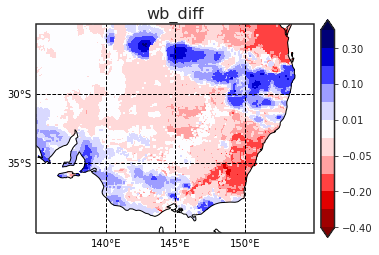

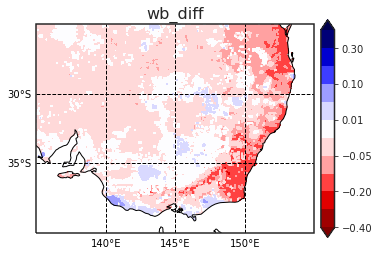

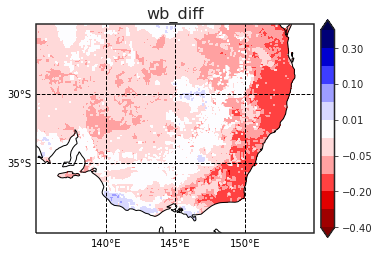

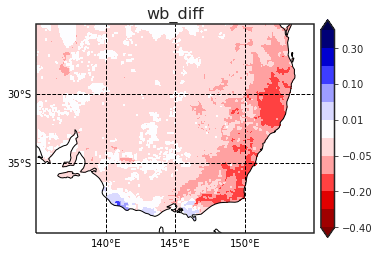

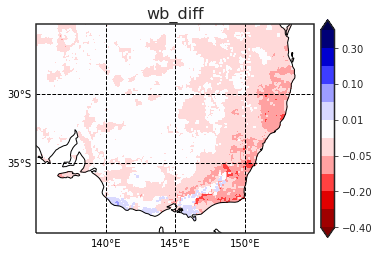

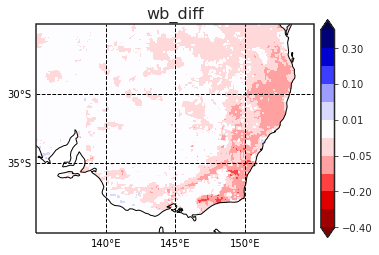

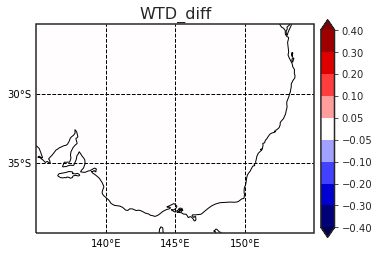

In [13]:
if __name__ == "__main__":
    case_name      = "drght_2017_2019_bl_pbl2_mp4_sf_sfclay2"
    dry_restart    = "/g/data/w97/mm3972/model/wrf/NUWRF/LISWRF_configs/offline_rst_output/output_1719_drght/"+case_name+"/LIS_RST_CABLE_201912011100.d01.nc_offrst_201912012100"
    cli_restart    = "/g/data/w97/mm3972/model/wrf/NUWRF/LISWRF_configs/offline_rst_output/output_1719_drght/"+case_name+"/LIS_RST_CABLE_201912011100.d01.nc_offrst_201912012100+1970-199912012100_mean_SM"
    file_path      = "/g/data/w97/mm3972/model/wrf/NUWRF/LISWRF_configs/drght_2017_2019_bl_pbl2_mp4_sf_sfclay2/LIS_output/LIS.CABLE.201711-201711.d01.nc"
    wrf_path       = "/g/data/w97/mm3972/model/wrf/NUWRF/LISWRF_configs/drght_2017_2019_bl_pbl2_mp4_sf_sfclay2/WRF_output/wrfout_d01_2017-01-01_11:00:00"
    spatial_map_single_plot_diff(cli_restart, dry_restart, file_path, wrf_path)
    
    
    